In [9]:
import numpy as np
from glob import glob
import cv2
from random import randint

from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Lambda
from keras.models import Model, Input
import keras.backend as K
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping

# import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

from threading import Thread

IMG_HEIGHT = 256
IMG_WIDTH = 256
AB_PAIRS = 676 # (255//10) ** 2
#AB_PAIRS = 313 # total numbers of ab pairs, according to paper.

# local
RUN = 0
# DATA_DIR = '../SSD/VOCdevkit/VOC2007/JPEGImages'
# LOG_DIR = './output/training_logs/run{}'.format(RUN)
# SAVE_DIR = './creation'

# cloud
DATA_DIR = './kaggle_simpson_testset'
LOG_DIR = '/output/training_logs/run{}'.format(RUN)
SAVE_DIR = '/input/Colorization/creation'

# DATA_DIR = './VOCdevkit/VOC2012/JPEGImages'
# LOG_DIR = '/output/training_logs/more-run-{}'.format(RUN)
# SAVE_DIR = '/input/Colorization/creation2'


LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'
file_glob = glob('{}/*.jpg'.format(DATA_DIR))

In [10]:
def get_model():
    img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    x = img_input
    print(x.get_shape())

    # conv1
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv2
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv3
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv4
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    # yes, strides of last Conv2D is 1, according to author's implementation, seach 'name: "conv4_3"' in 
    # https://raw.githubusercontent.com/richzhang/colorization/master/models/colorization_deploy_v2.prototxt
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv 5
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv 6
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=2, activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv 7
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    x = BatchNormalization()(x)
    print(x.get_shape())

    # conv 8
    print('conv 8')
    # TODO 这里Conv2DTranspose后无法获得size
    # x = Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same', dilation_rate=1, activation='relu')(x)
    x = UpSampling2D(size=2)(x)
    print(x.get_shape())
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    print(x.get_shape())
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    # x = BatchNormalization()(x)
    print(x.get_shape())

    # Softmax
    # remap 256 to AB_PAIRS(313) with kernel_size = 1
    x = Conv2D(filters=AB_PAIRS, kernel_size=1, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    print(x.get_shape())
    
    
    curr_height, curr_width = int(x.get_shape().dims[1]), int(x.get_shape().dims[2])
    print(curr_height, curr_width)

    def reshape(x):
        x = K.reshape(x, (-1, AB_PAIRS))
        print(x.get_shape())

        x = K.softmax(x)
        print(x.get_shape())

        x = K.reshape(x, (-1, curr_height, curr_width, AB_PAIRS))
        print(x.get_shape())

        # resize_images(x, height_factor, width_factor, data_format)
        x = K.resize_images(x, IMG_HEIGHT / curr_height, IMG_WIDTH / curr_width, data_format="channels_last")
        print(x.get_shape())
        return x

    x = Lambda(lambda z: reshape(z), output_shape=(IMG_HEIGHT, IMG_WIDTH, AB_PAIRS))(x)

    # NO Below!!! 其实不需要下面这步了，就是上面的，和Y的对应的那个的cross entropy对比。
    # x = Conv2D(filters=2, kernel_size=1, strides=1, padding='same', dilation_rate=1, activation='relu')(x)
    print(x.get_shape())
    
    
    model = Model(inputs=img_input, outputs=x)
    # model.summary()

    # Try MSE
    # model.compile(loss='mse', optimizer='Adadelta')

    # Try ...
    model.compile(loss='categorical_crossentropy', optimizer='Adadelta')
    # model.compile(loss=categorical_crossentropy_color, optimizer='Adadelta')
    
    return model

```
def categorical_crossentropy_color_try(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
    
    # shape: (256, 256, 2)
    # Flatten
#     n, h, w, q = y_true.shape
    n, h, w, c = y_pred.shape
    print(n)
    print(type(n))
    y_true = K.reshape(y_true, (n * h * w, c))
    y_pred = K.reshape(y_pred, (n * h * w, c))

    weights = y_true[:, AB_PAIRS:]  # extract weight from y_true
    weights = K.concatenate([weights] * AB_PAIRS, axis=1)
    y_true = y_true[:, :-1]  # remove last column
    y_pred = y_pred[:, :-1]  # remove last column

    # multiply y_true by weights
    y_true = y_true * weights

    cross_entropy = K.categorical_crossentropy(y_pred, y_true)
    cross_entropy = K.mean(cross_entropy, axis=-1)

    return cross_entropy

# model.compile(loss=categorical_crossentropy_color, optimizer='Adadelta')
```

(?, 128, 128, 1)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
conv 8
(?, 32, 32, 512)
(?, 32, 32, 256)
(?, 32, 32, 256)
(?, 32, 32, 676)
32 32
(?, 676)
(?, 676)
(?, 32, 32, 676)
(?, 128, 128, 676)
(?, 128, 128, 676)


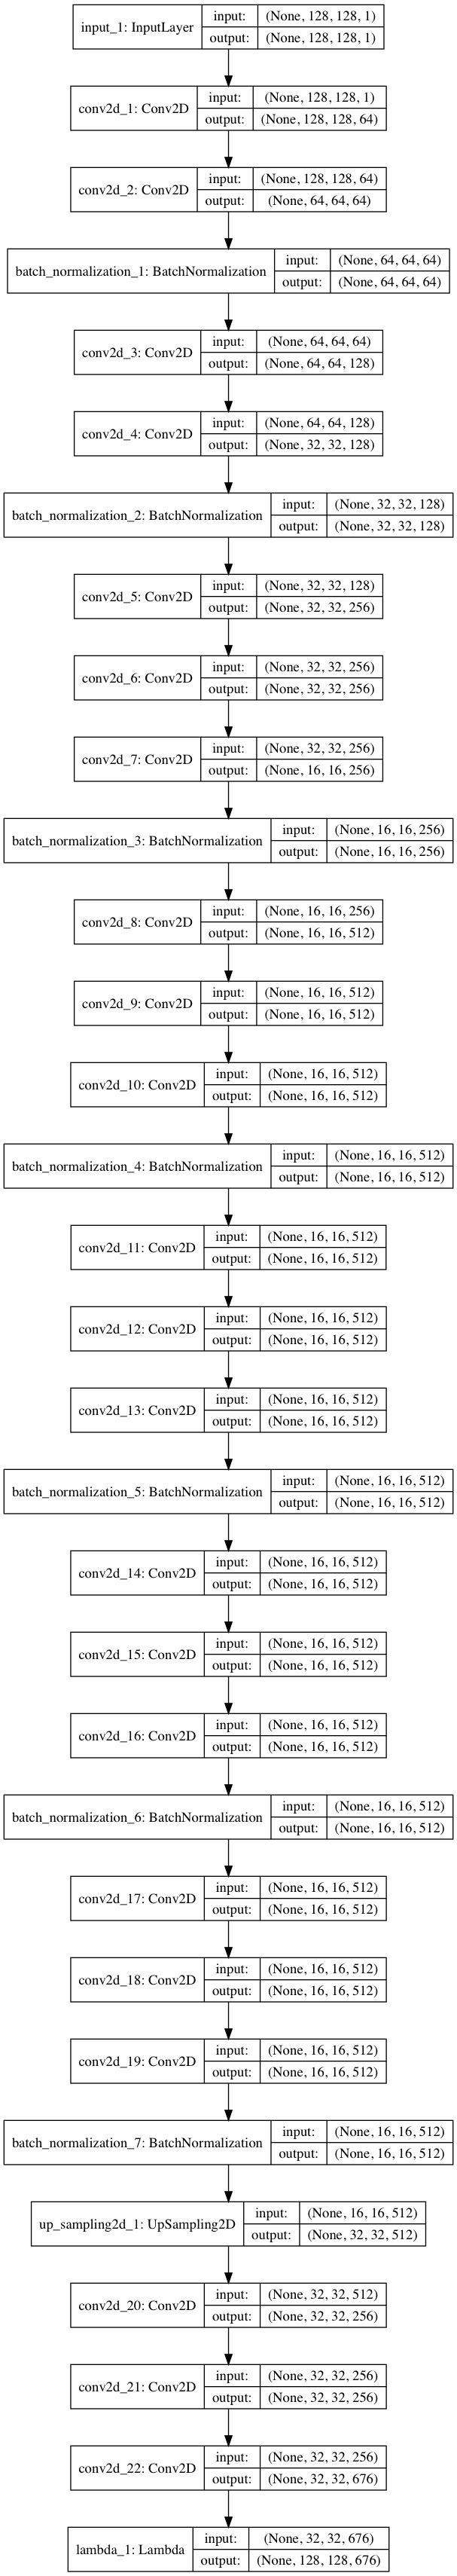

In [4]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(get_model(), to_file="/tmp/model.png", show_shapes=True)
Image('/tmp/model.png')

In [11]:
# Keras fit_generator already works parallelly
def handle_img(**kwargs):
    X = kwargs['X']
    y = kwargs['y']
    i = kwargs['i']
    path = kwargs['path']
    random_choose = kwargs['random_choose']
    
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    channel_L = np.expand_dims(img[:,:,0], axis=2)
    
    ab_channel_one_hot = np.zeros((IMG_HEIGHT, IMG_WIDTH, AB_PAIRS), dtype=np.float32)
    for j in range(IMG_HEIGHT):
        for k in range(IMG_WIDTH):
            # 255 -> 25.5 -> 26 -> bugs
            a = min(254, img[j, k, 1])
            b = min(254, img[j, k, 2])
            hot_pos = int(round(a / 10) * 26 + round(b / 10))
            ab_channel_one_hot[j, k, hot_pos] = 1.
    
    X[i] = channel_L - 128.
    y[i] = ab_channel_one_hot

# generator in multi-threading
def multi_thread_gen(batch_size=8, random_choose=False):
    idx = 0
    while True:
        X = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
        y = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, AB_PAIRS), dtype=np.float32)
        
        if random_choose:
            idx = randint(0, len(file_glob) - batch_size - 1)
        
        threads = []
        for i in range(batch_size):
            kwargs = {
                'i':i,
                'path':file_glob[idx+i],
                'X': X,
                'y': y,
                'random_choose': random_choose,
            }
            t = Thread(target=handle_img, kwargs=kwargs)
            threads.append(t)
            t.start()

        for t in threads:
            t.join()
            
        idx += batch_size
        if idx + batch_size >= len(file_glob):
            idx = 0
        
        yield X, y

In [12]:
def gen(batch_size=8, random_choose=False):
    idx = 0
    while True:
        X = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
        y = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, AB_PAIRS), dtype=np.float32)
        
        if random_choose:
            idx = randint(0, len(file_glob) - batch_size - 1)
        
        for i in range(batch_size):
            img = cv2.imread(file_glob[idx+i])
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

            channel_L = np.expand_dims(img[:,:,0], axis=2)

            ab_channel_one_hot = np.zeros((IMG_HEIGHT, IMG_WIDTH, AB_PAIRS), dtype=np.float32)
            for j in range(IMG_HEIGHT):
                for k in range(IMG_WIDTH):
                    # 255 -> 25.5 -> 26 -> bugs
                    a = min(254, img[j, k, 1])
                    b = min(254, img[j, k, 2])
                    hot_pos = int(round(a / 10) * 26 + round(b / 10))
                    ab_channel_one_hot[j, k, hot_pos] = 1.

            X[i] = channel_L - 128.
            y[i] = ab_channel_one_hot

        idx += batch_size
        if idx + batch_size >= len(file_glob):
            idx = 0
        
        yield X, y

In [13]:
A,B = next(gen(1))
A.shape, B.shape

((1, 256, 256, 1), (1, 256, 256, 676))

In [14]:
class ColorizationEvaluator(Callback):
    def __init__(self):
        self.gen = gen(1, random_choose=True)
        
    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = next(self.gen) # (1, 128, 128, 1)
        y_pred = self.model.predict(X_test) # (1, 128, 128, AB_PAIRS)
        X_test, y_test, y_pred = X_test[0], y_test[0], y_pred[0]
        X_test += 128.
        
        img_truth = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        img_pred = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        
        img_truth[:,:,0] = X_test[:,:,0]
        img_pred[:,:,0] = X_test[:,:,0]
        
        for i in range(IMG_HEIGHT):
            for j in range(IMG_WIDTH):                
                truth_pos = np.argmax(y_test[i, j])
                pred_pos = np.argmax(y_pred[i, j])

                img_truth[i, j, 1] = min(255, (truth_pos // 26) * 10)
                img_truth[i, j, 2] = min(255, (truth_pos % 26) * 10)
                img_pred[i, j, 1] = min(255, (pred_pos // 26) * 10)
                img_pred[i, j, 2] = min(255, (pred_pos % 26) * 10)
        
        img_merged = np.concatenate([img_truth, img_pred], axis=1)
        # .astype(np.uint8) VERY IMPORTANT
        img_merged = img_merged.astype(np.uint8)
        img_merged_bgr = cv2.cvtColor(img_merged, cv2.COLOR_LAB2BGR)
        img_merged_rgb = cv2.cvtColor(img_merged, cv2.COLOR_LAB2RGB)
        
        # write BGR format
        cv2.imwrite("{}/epoch-{}.png".format(SAVE_DIR, epoch), img_merged_bgr)
        
        # display RGB format
        plt.imshow(img_merged_rgb)
        plt.show()

(?, 128, 128, 1)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
conv 8
(?, 32, 32, 512)
(?, 32, 32, 256)
(?, 32, 32, 256)
(?, 32, 32, 676)
32 32
(?, 676)
(?, 676)
(?, 32, 32, 676)
(?, 128, 128, 676)
(?, 128, 128, 676)
model built
RUN 2
Epoch 1/10000
63/64 [============================>.] - ETA: 1s - loss: 5.1542Epoch 00000: val_loss improved from inf to 8.36870, saving model to /output/training_logs/run0/checkpoint-00-8.3687.hdf5


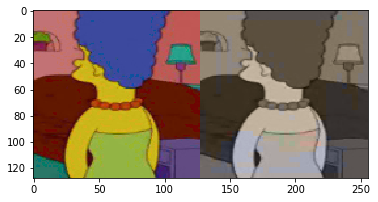

64/64 [==============================] - 138s - loss: 5.1478 - val_loss: 8.3687
Epoch 2/10000
63/64 [============================>.] - ETA: 1s - loss: 4.6548Epoch 00001: val_loss improved from 8.36870 to 5.20572, saving model to /output/training_logs/run0/checkpoint-01-5.2057.hdf5


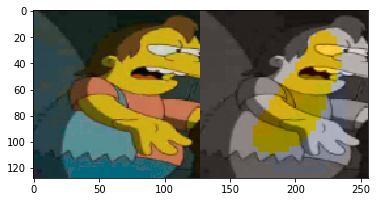

64/64 [==============================] - 123s - loss: 4.6460 - val_loss: 5.2057
Epoch 3/10000
63/64 [============================>.] - ETA: 1s - loss: 4.6264Epoch 00002: val_loss improved from 5.20572 to 4.84348, saving model to /output/training_logs/run0/checkpoint-02-4.8435.hdf5


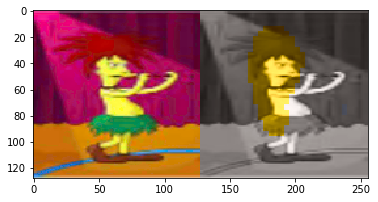

64/64 [==============================] - 123s - loss: 4.6199 - val_loss: 4.8435
Epoch 4/10000
63/64 [============================>.] - ETA: 1s - loss: 4.5430Epoch 00003: val_loss improved from 4.84348 to 4.47309, saving model to /output/training_logs/run0/checkpoint-03-4.4731.hdf5


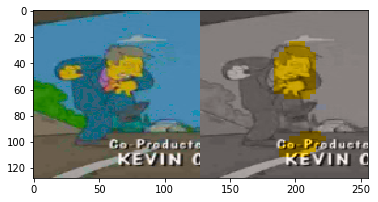

64/64 [==============================] - 123s - loss: 4.5365 - val_loss: 4.4731
Epoch 5/10000
63/64 [============================>.] - ETA: 1s - loss: 4.5189Epoch 00004: val_loss improved from 4.47309 to 4.41268, saving model to /output/training_logs/run0/checkpoint-04-4.4127.hdf5


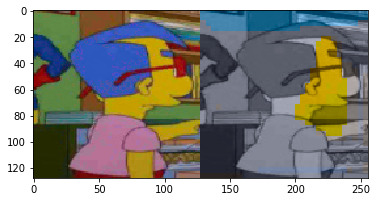

64/64 [==============================] - 123s - loss: 4.5190 - val_loss: 4.4127
Epoch 6/10000
63/64 [============================>.] - ETA: 1s - loss: 4.4474Epoch 00005: val_loss did not improve


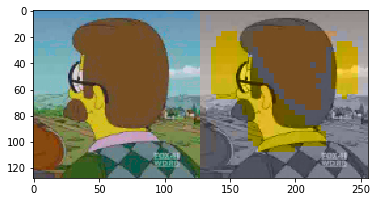

64/64 [==============================] - 121s - loss: 4.4502 - val_loss: 4.4830
Epoch 7/10000
63/64 [============================>.] - ETA: 1s - loss: 4.4428Epoch 00006: val_loss did not improve


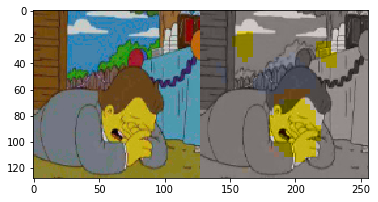

64/64 [==============================] - 122s - loss: 4.4416 - val_loss: 4.7265
Epoch 8/10000
63/64 [============================>.] - ETA: 1s - loss: 4.4183Epoch 00007: val_loss did not improve


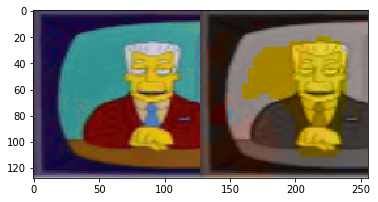

64/64 [==============================] - 123s - loss: 4.4143 - val_loss: 4.9117
Epoch 9/10000
63/64 [============================>.] - ETA: 1s - loss: 4.4129Epoch 00008: val_loss did not improve


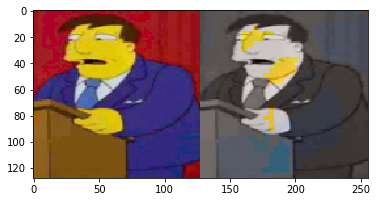

64/64 [==============================] - 121s - loss: 4.4100 - val_loss: 4.7527
Epoch 10/10000
63/64 [============================>.] - ETA: 1s - loss: 4.3809Epoch 00009: val_loss did not improve


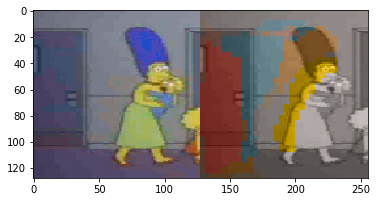

64/64 [==============================] - 122s - loss: 4.3782 - val_loss: 4.6956
Epoch 11/10000
63/64 [============================>.] - ETA: 1s - loss: 4.3968Epoch 00010: val_loss did not improve


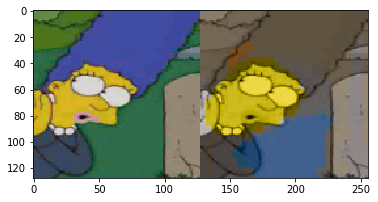

64/64 [==============================] - 122s - loss: 4.3870 - val_loss: 4.6273
Epoch 00010: early stopping


In [7]:
model = get_model()
print('model built')

RUN = RUN + 1 if 'RUN' in locals() else 1
print("RUN {}".format(RUN))

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
evaluator = ColorizationEvaluator()

history = model.fit_generator(generator=gen(8), steps_per_epoch=64,
                              validation_data=gen(8, random_choose=True), validation_steps=8,
                              epochs=10000, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])
# history = model.fit_generator(generator=multi_thread_gen(8), steps_per_epoch=64,
#                               validation_data=multi_thread_gen(8, random_choose=True), validation_steps=8,
#                               epochs=10000, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

# history = model.fit_generator(generator=multi_thread_gen(1), steps_per_epoch=1,
#                               validation_data=multi_thread_gen(1, random_choose=True), validation_steps=1,
#                               epochs=32, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

# history = model.fit_generator(generator=gen(1), steps_per_epoch=1,
#                               validation_data=gen(1, random_choose=True), validation_steps=1,
#                               epochs=32, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

(?, 128, 128, 1)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
(?, 16, 16, 512)
conv 8
(?, 32, 32, 512)
(?, 32, 32, 256)
(?, 32, 32, 256)
(?, 32, 32, 676)
32 32
(?, 676)
(?, 676)
(?, 32, 32, 676)
(?, 128, 128, 676)
(?, 128, 128, 676)
model built
RUN 3
Epoch 1/10000
63/64 [============================>.] - ETA: 1s - loss: 3.8721Epoch 00000: val_loss improved from inf to 3.94366, saving model to /output/training_logs/more-run-2/checkpoint-00-3.9437.hdf5


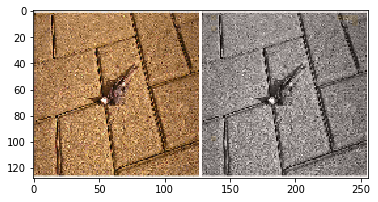

64/64 [==============================] - 140s - loss: 3.8752 - val_loss: 3.9437
Epoch 2/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2946Epoch 00001: val_loss did not improve


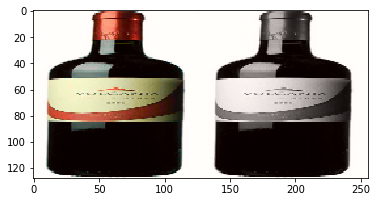

64/64 [==============================] - 122s - loss: 3.3030 - val_loss: 4.9841
Epoch 3/10000
63/64 [============================>.] - ETA: 1s - loss: 3.3417Epoch 00002: val_loss improved from 3.94366 to 3.16082, saving model to /output/training_logs/more-run-2/checkpoint-02-3.1608.hdf5


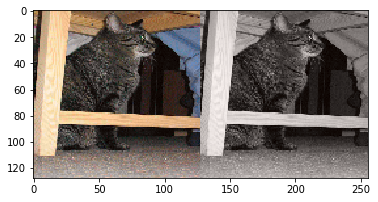

64/64 [==============================] - 123s - loss: 3.3521 - val_loss: 3.1608
Epoch 4/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2380Epoch 00003: val_loss did not improve


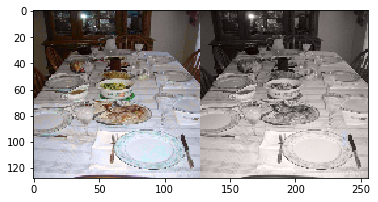

64/64 [==============================] - 126s - loss: 3.2455 - val_loss: 3.4044
Epoch 5/10000
63/64 [============================>.] - ETA: 1s - loss: 3.3815Epoch 00004: val_loss did not improve


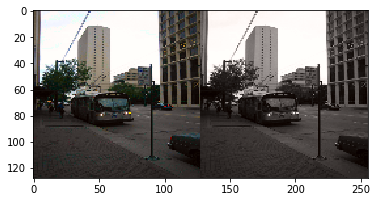

64/64 [==============================] - 125s - loss: 3.3770 - val_loss: 3.2375
Epoch 6/10000
63/64 [============================>.] - ETA: 1s - loss: 3.3270Epoch 00005: val_loss improved from 3.16082 to 3.11476, saving model to /output/training_logs/more-run-2/checkpoint-05-3.1148.hdf5


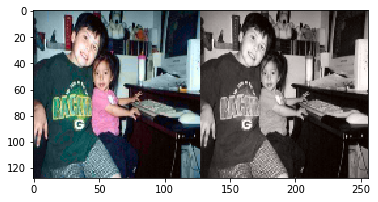

64/64 [==============================] - 124s - loss: 3.3316 - val_loss: 3.1148
Epoch 7/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2445Epoch 00006: val_loss did not improve


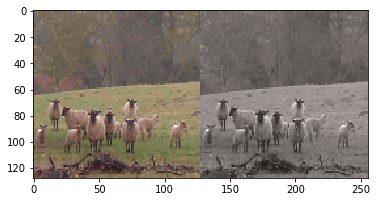

64/64 [==============================] - 123s - loss: 3.2488 - val_loss: 3.9477
Epoch 8/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2554Epoch 00007: val_loss did not improve


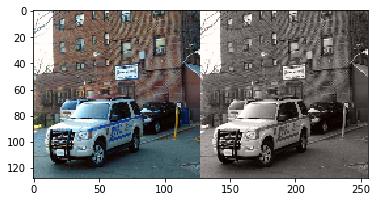

64/64 [==============================] - 124s - loss: 3.2637 - val_loss: 3.9408
Epoch 9/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2752Epoch 00008: val_loss improved from 3.11476 to 3.03344, saving model to /output/training_logs/more-run-2/checkpoint-08-3.0334.hdf5


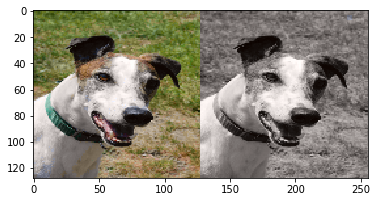

64/64 [==============================] - 123s - loss: 3.2793 - val_loss: 3.0334
Epoch 10/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2492Epoch 00009: val_loss did not improve


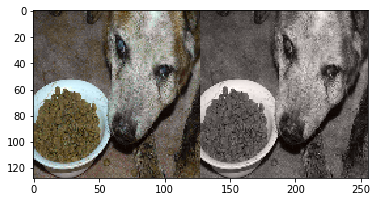

64/64 [==============================] - 123s - loss: 3.2340 - val_loss: 3.3225
Epoch 11/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2053Epoch 00010: val_loss did not improve


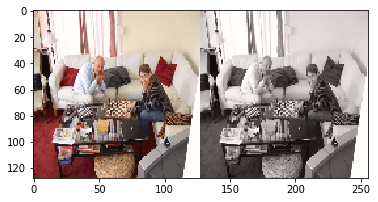

64/64 [==============================] - 123s - loss: 3.1980 - val_loss: 3.1327
Epoch 12/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2710Epoch 00011: val_loss did not improve


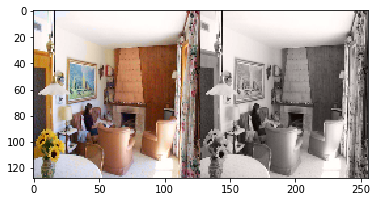

64/64 [==============================] - 122s - loss: 3.2638 - val_loss: 3.1642
Epoch 13/10000
63/64 [============================>.] - ETA: 1s - loss: 3.1875Epoch 00012: val_loss did not improve


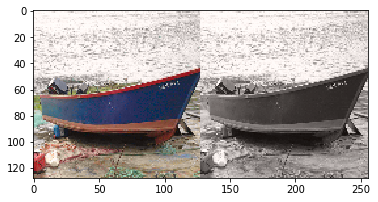

64/64 [==============================] - 123s - loss: 3.1812 - val_loss: 3.6088
Epoch 14/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2292Epoch 00013: val_loss did not improve


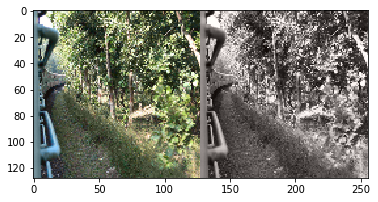

64/64 [==============================] - 124s - loss: 3.2330 - val_loss: 3.4250
Epoch 15/10000
63/64 [============================>.] - ETA: 1s - loss: 3.2337Epoch 00014: val_loss did not improve


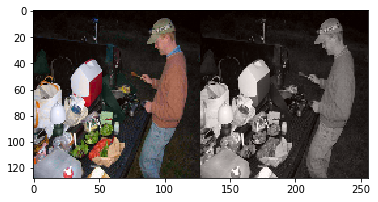

64/64 [==============================] - 123s - loss: 3.2304 - val_loss: 3.2989
Epoch 00014: early stopping


In [8]:
DATA_DIR = './VOCdevkit/VOC2012/JPEGImages'
LOG_DIR = '/output/training_logs/more-run-{}'.format(RUN)
SAVE_DIR = '/input/Colorization/creation2'

LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'
file_glob = glob('{}/*.jpg'.format(DATA_DIR))

model = get_model()
print('model built')

RUN = RUN + 1 if 'RUN' in locals() else 1
print("RUN {}".format(RUN))

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
evaluator = ColorizationEvaluator()

history = model.fit_generator(generator=gen(8), steps_per_epoch=64,
                              validation_data=gen(8, random_choose=True), validation_steps=8,
                              epochs=10000, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

(?, 256, 256, 1)
(?, 128, 128, 64)
(?, 64, 64, 128)
(?, 32, 32, 256)
(?, 32, 32, 512)
(?, 32, 32, 512)
(?, 32, 32, 512)
(?, 32, 32, 512)
conv 8
(?, 64, 64, 512)
(?, 64, 64, 256)
(?, 64, 64, 256)
(?, 64, 64, 676)
64 64
(?, 676)
(?, 676)
(?, 64, 64, 676)
(?, 256, 256, 676)
(?, 256, 256, 676)
model built
RUN 1
Epoch 1/10000
63/64 [============================>.] - ETA: 6s - loss: 3.9715 Epoch 00000: val_loss improved from inf to 6.98615, saving model to /output/training_logs/more-run-0/checkpoint-00-6.9862.hdf5


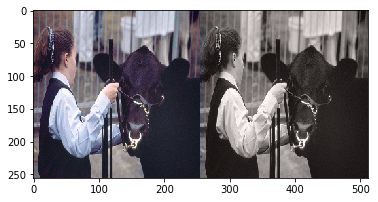

64/64 [==============================] - 575s - loss: 3.9743 - val_loss: 6.9862
Epoch 2/10000
63/64 [============================>.] - ETA: 6s - loss: 3.2427 Epoch 00001: val_loss improved from 6.98615 to 5.18777, saving model to /output/training_logs/more-run-0/checkpoint-01-5.1878.hdf5


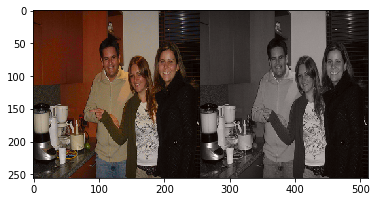

64/64 [==============================] - 524s - loss: 3.2493 - val_loss: 5.1878
Epoch 3/10000
63/64 [============================>.] - ETA: 6s - loss: 3.2397 Epoch 00002: val_loss improved from 5.18777 to 3.79842, saving model to /output/training_logs/more-run-0/checkpoint-02-3.7984.hdf5


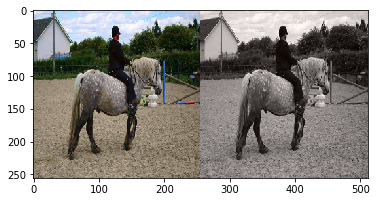

64/64 [==============================] - 531s - loss: 3.2461 - val_loss: 3.7984
Epoch 4/10000
63/64 [============================>.] - ETA: 6s - loss: 3.0894 Epoch 00003: val_loss improved from 3.79842 to 3.59640, saving model to /output/training_logs/more-run-0/checkpoint-03-3.5964.hdf5


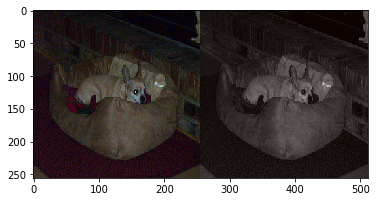

64/64 [==============================] - 532s - loss: 3.0931 - val_loss: 3.5964
Epoch 5/10000
63/64 [============================>.] - ETA: 6s - loss: 3.2273 Epoch 00004: val_loss improved from 3.59640 to 3.44780, saving model to /output/training_logs/more-run-0/checkpoint-04-3.4478.hdf5


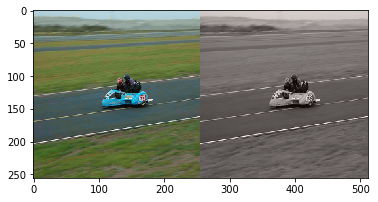

64/64 [==============================] - 523s - loss: 3.2317 - val_loss: 3.4478
Epoch 6/10000
63/64 [============================>.] - ETA: 6s - loss: 3.2035 Epoch 00005: val_loss improved from 3.44780 to 3.23736, saving model to /output/training_logs/more-run-0/checkpoint-05-3.2374.hdf5


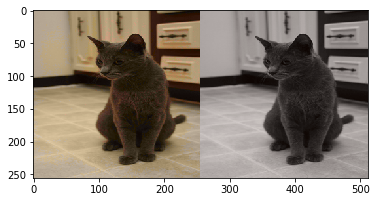

64/64 [==============================] - 532s - loss: 3.2110 - val_loss: 3.2374
Epoch 7/10000
63/64 [============================>.] - ETA: 6s - loss: 3.1327 Epoch 00006: val_loss improved from 3.23736 to 3.17251, saving model to /output/training_logs/more-run-0/checkpoint-06-3.1725.hdf5


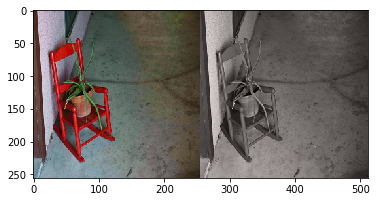

64/64 [==============================] - 532s - loss: 3.1343 - val_loss: 3.1725
Epoch 8/10000
63/64 [============================>.] - ETA: 6s - loss: 3.1441 Epoch 00007: val_loss did not improve


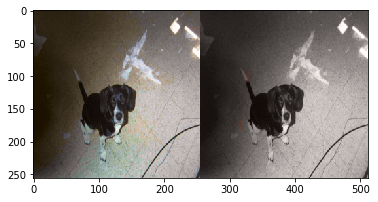

64/64 [==============================] - 521s - loss: 3.1524 - val_loss: 3.6437
Epoch 9/10000
63/64 [============================>.] - ETA: 6s - loss: 3.1494 Epoch 00008: val_loss improved from 3.17251 to 2.90895, saving model to /output/training_logs/more-run-0/checkpoint-08-2.9090.hdf5


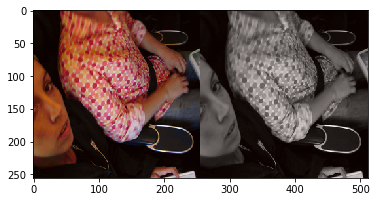

64/64 [==============================] - 528s - loss: 3.1525 - val_loss: 2.9090
Epoch 10/10000
63/64 [============================>.] - ETA: 6s - loss: 3.1049 Epoch 00009: val_loss did not improve


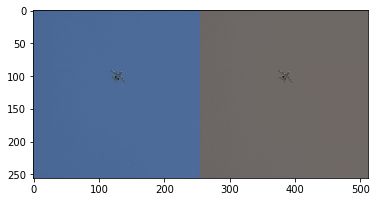

64/64 [==============================] - 528s - loss: 3.0900 - val_loss: 3.5205
Epoch 11/10000
63/64 [============================>.] - ETA: 6s - loss: 3.0734 Epoch 00010: val_loss did not improve


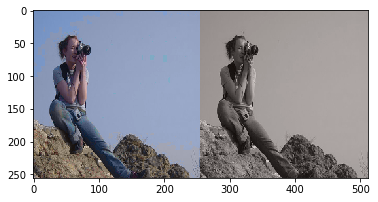

64/64 [==============================] - 525s - loss: 3.0655 - val_loss: 3.1525
Epoch 12/10000
63/64 [============================>.] - ETA: 6s - loss: 3.1331 Epoch 00011: val_loss did not improve


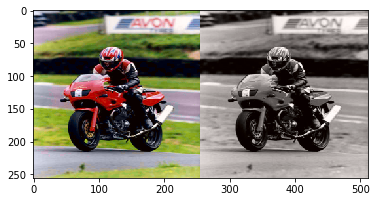

64/64 [==============================] - 524s - loss: 3.1257 - val_loss: 2.9941
Epoch 13/10000
63/64 [============================>.] - ETA: 6s - loss: 3.0612 Epoch 00012: val_loss did not improve


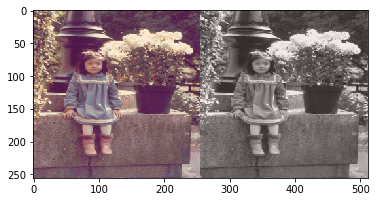

64/64 [==============================] - 523s - loss: 3.0542 - val_loss: 3.0296
Epoch 14/10000
63/64 [============================>.] - ETA: 6s - loss: 3.0814 Epoch 00013: val_loss did not improve


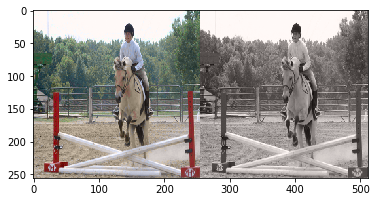

64/64 [==============================] - 529s - loss: 3.0839 - val_loss: 3.0691
Epoch 15/10000
 5/64 [=>............................] - ETA: 98s - loss: 3.0278

KeyboardInterrupt: 

In [15]:
DATA_DIR = './VOCdevkit/VOC2012/JPEGImages'
LOG_DIR = '/output/training_logs/more-run-{}'.format(RUN)
SAVE_DIR = '/input/Colorization/creation2'

LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'
file_glob = glob('{}/*.jpg'.format(DATA_DIR))

model = get_model()
print('model built')

RUN = RUN + 1 if 'RUN' in locals() else 1
print("RUN {}".format(RUN))

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
evaluator = ColorizationEvaluator()

history = model.fit_generator(generator=gen(8), steps_per_epoch=64,
                              validation_data=gen(8, random_choose=True), validation_steps=8,
                              epochs=10000, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping, evaluator])

In [13]:
def show(img, pattern):
    _img = cv2.cvtColor(img, pattern)
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].imshow(_img[:,:,0], cmap='gray')
    axs[1].imshow(_img[:,:,1], cmap='gray')
    axs[2].imshow(_img[:,:,2], cmap='gray')
#     fig.show()

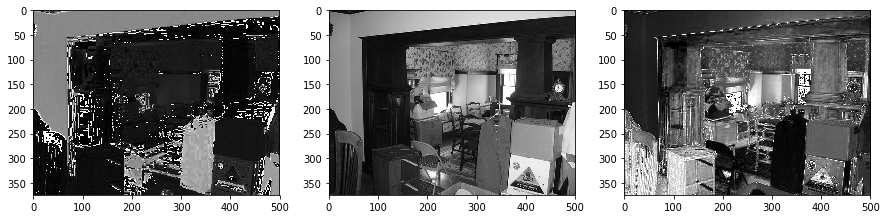

In [14]:
img = cv2.imread('../SSD/VOCdevkit/VOC2007/JPEGImages/000005.jpg')
show(img, cv2.COLOR_BGR2HLS)

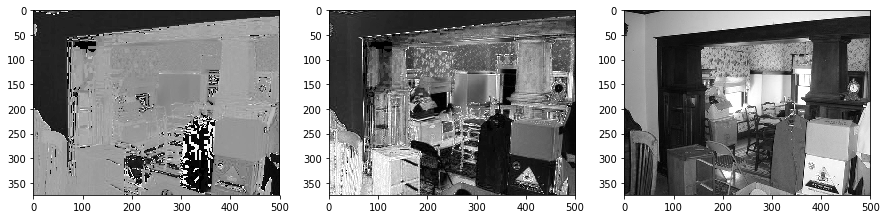

In [15]:
show(img, cv2.COLOR_RGB2HSV)

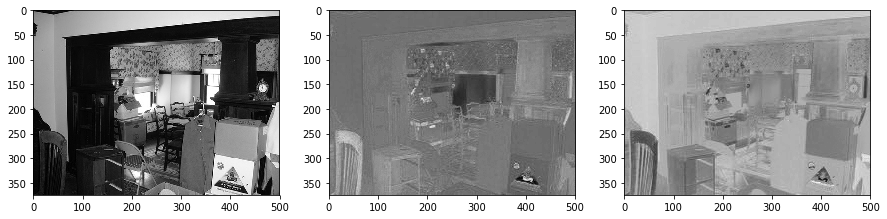

In [16]:
show(img, cv2.COLOR_RGB2LAB)

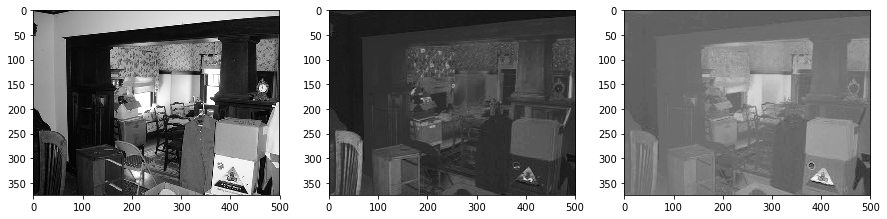

In [177]:
show(img, cv2.COLOR_RGB2LUV)

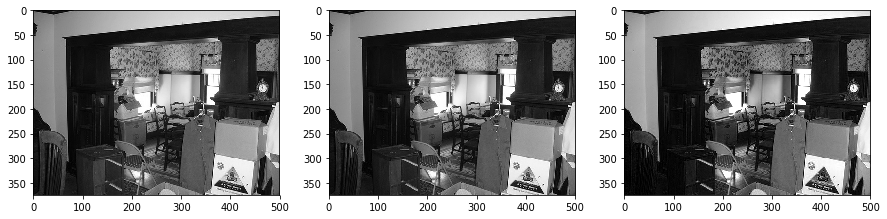

In [178]:
show(img, cv2.COLOR_RGB2XYZ)

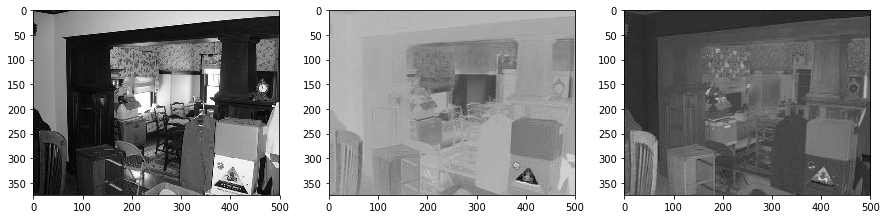

In [179]:
show(img, cv2.COLOR_RGB2YUV)

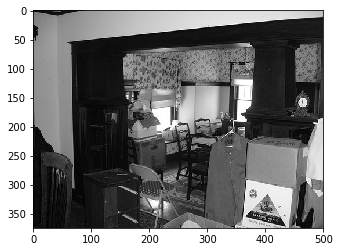

In [30]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')